In [15]:
import numpy as np
import matplotlib.pyplot as plt

k_B = 8.617333262*1e-05  # Boltzmann constant in eV/K

class IsingModel2D:

    def __init__(self, lattice_length, J=1, H=0):
        """
        Initialize the Ising model with a given lattice size, interaction strength J, and external field H.

        Parameters:
        lattice_length (int): The size of the lattice (LxL).
        J (float, optional): The coupling constant in eV (default is 1).
        H (float, optional): The external magnetic field in T (default is 0).
        """
        self.lattice_length = lattice_length
        self.J = J
        self.H = H
        self._initialize_lattice()


    @property
    def lattice(self):
        """
        Return the lattice configuration.

        Returns:
        np.ndarray: The current state of the lattice (2D array of spins).
        """
        return self._lattice


    def _initialize_lattice(self):
        """
        Initialize an LxL lattice with random spins (+1 or -1).
        """
        L = self.lattice_length
        self._lattice = np.random.choice([-1, 1], size=(L, L))


    def flip_site(self, i, j):
        """
        Flip the spin at site (i, j).
        """
        self._lattice[i, j] *= -1


    def get_site_energy(self, i, j):
        """
        Compute the energy contribution of a given lattice site (i, j).

        Returns:
        float: The energy of the site (including spin coupling and external field).
        """
        lattice = self.lattice
        muB = 5.788 * 1e-05 # Bohr magneton in eV/T
        S = lattice[i, j]
        L = self.lattice_length
        neighbors = lattice[(i+1)%L, j] + lattice[i, (j+1)%L] + lattice[(i-1)%L, j] + lattice[i, (j-1)%L] 
        site_energy = -1 * self.J * S * neighbors - 1 * muB * self.H * S  # Spin coupling + external magnetic field
        return site_energy


    def get_delta_energy(self, i, j):
        """
        Calculate the energy difference if the spin at (i, j) is flipped.

        Returns:
        float: The energy change.
        """
        site_energy = self.get_site_energy(i, j)
        return -2 * site_energy


    def get_total_energy(self):
        """
        Compute the total energy of the lattice.

        Returns:
        float: The total energy of the lattice.
        """
        energy = 0
        lattice = self.lattice
        J = self.J
        L = lattice.shape[0]
        for i in range(L):
            for j in range(L):
                energy += self.get_site_energy(i, j)
        return energy / 2  # Each pair counted twice


    def metropolis_step(self, temperature):
        """
        Perform one Metropolis step on the lattice.

        Parameters:
        temperature (float): The temperature of the system.
        """
        L = self.lattice.shape[0]
        for _ in range(L**2):  # L^2 updates per step
            i, j = np.random.randint(0, L, size=2)
            dE = self.get_delta_energy(i, j)
            if dE < 0 or np.random.rand() < np.exp(-1 / (temperature) * dE):
                self.flip_site(i, j)  # Flip spin


    def run_monte_carlo_simulation(self, temperature, number_of_steps=1000, plot_every_nstep=None, colormap='seismic'):
        """
        Run the Monte Carlo simulation for a given number of steps and temperature.

        Parameters:
        temperature (float): The temperature of the system.
        number_of_steps (int, optional): The number of Monte Carlo steps to perform (default is 1000).
        plot_every_nstep (int, optional): The interval at which to plot the lattice configuration (default is None).

        Returns:
        list: A list of total energies after each step.
        """
        self._initialize_lattice()
        energies = []
        for step_number in range(number_of_steps):
            if plot_every_nstep is not None:
                if step_number % plot_every_nstep == 0:
                    self.plot_lattice(title=f'step={step_number}') 
            
            self.metropolis_step(temperature=temperature)
            energies.append(self.get_total_energy())
  
        return energies


    def plot_lattice(self, colormap='seismic', title="2D Ising Model Configuration"):
        """
        Plot the lattice configuration.

        Parameters:
        colormap (str, optional): The colormap to use for visualization (default is 'magma').
        title (str, optional): The title for the plot (default is "2D Ising Model Configuration").

        Returns:
        matplotlib.pyplot: The matplotlib pyplot object used for plotting.
        """
        plt.imshow(self.lattice, cmap=colormap, interpolation='nearest',vmin=-1,vmax=1)
        plt.title(title)
        plt.show()
        return plt


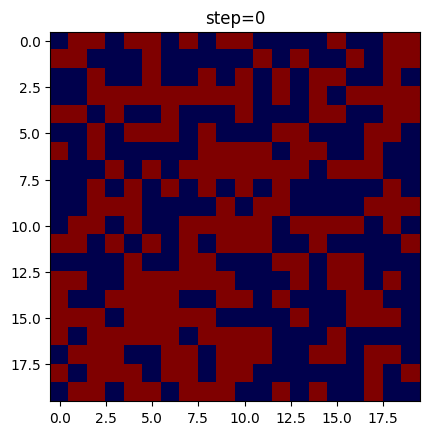

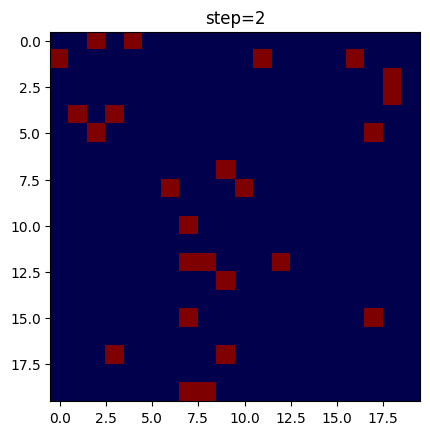

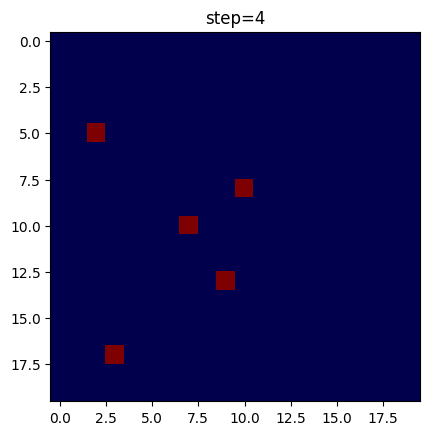

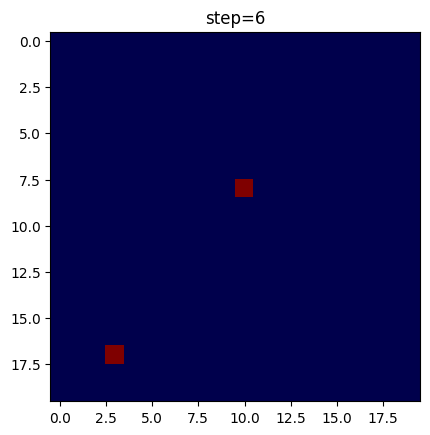

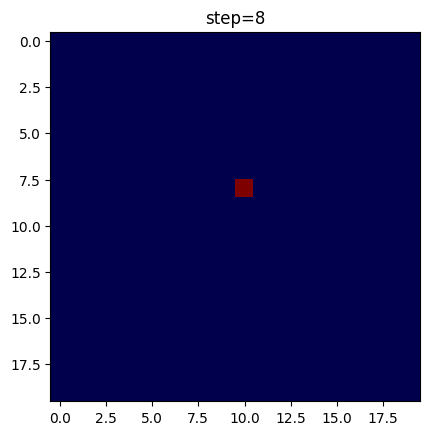

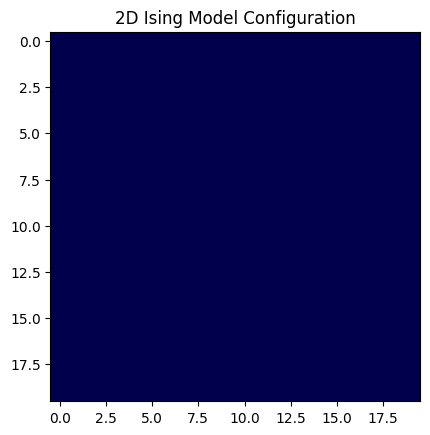

<module 'matplotlib.pyplot' from '/nfshome/villa/miniconda3/envs/pynter/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [17]:
model = IsingModel2D(lattice_length=20,J=0,H=-1e05)
energies = model.run_monte_carlo_simulation(temperature=1,number_of_steps=10,plot_every_nstep=2)
model.plot_lattice(colormap='seismic')